In [7]:
# Gerekli Kütüphaneler
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Grafik Stili
plt.style.use('ggplot')

# --- AYARLAR ---
SEMBOL = 'BTC-USD'    # Tahmin edilecek coin (örn: ETH-USD, SOL-USD)
BASLANGIC = '2020-01-01'
SEQ_LEN = 60          # Geçmiş kaç güne bakarak tahmin yapsın?
EPOCHS = 50           # Eğitim tur sayısı
BATCH_SIZE = 32       # Her turda işlenecek veri paketi
TAHMIN_GUNU = 1       # Kaç gün sonrasını tahmin etsin?

print(f"{SEMBOL} analizi için kütüphaneler yüklendi.")


BTC-USD analizi için kütüphaneler yüklendi.


In [25]:
# --- HÜCRE 2: VERİ ÇEKME VE BİRLEŞTİRME (DÜZELTİLMİŞ v2) ---

def tekil_veri_getir(ticker, ozel_isim):
    """
    Veriyi indirir ve sütun ismini zorla 'ozel_isim' yapar.
    Karmaşık MultiIndex yapılarını yok eder.
    """
    # Veriyi indir
    df = yf.download(ticker, start=BASLANGIC, progress=False, auto_adjust=True)
    
    # Eğer veri boşsa hata vermemesi için boş dataframe döndür
    if df.empty:
        return pd.DataFrame()

    # Eğer Sütunlar MultiIndex ise (örn: ('Close', 'BTC-USD')) düzleştir
    if isinstance(df.columns, pd.MultiIndex):
        # Genelde 'Close' 0. seviyededir, onu almaya çalış
        try:
            # 'Close' isimli seviyeyi çek
            df = df.xs('Close', axis=1, level=0, drop_level=True)
        except KeyError:
            # Eğer 'Close' diye bir seviye yoksa, dümdüz ilk sütunu al
            df = df.iloc[:, 0].to_frame()
    
    # Eğer zaten düz ise ama 'Close' sütunu varsa onu al
    elif 'Close' in df.columns:
        df = df[['Close']]
    else:
        # Hiçbiri yoksa ilk sütunu al (Garanti yöntem)
        df = df.iloc[:, 0].to_frame()

    # Pandas Series (tek sütun) dönerse DataFrame'e çevir
    if isinstance(df, pd.Series):
        df = df.to_frame()
        
    # Sütun ismini zorla değiştir
    df.columns = [ozel_isim]
    return df

def veri_hazirla_multi_asset_garanti(sembol, baslangic):
    print("Piyasa verileri toplanıyor... (BTC, Altın, Gümüş)")
    
    # 1. Her veriyi tek tek çekip ismini değiştiriyoruz
    df_btc = tekil_veri_getir(sembol, 'BTC_Close')
    df_gold = tekil_veri_getir('GC=F', 'Gold_Close')
    df_silver = tekil_veri_getir('SI=F', 'Silver_Close')

    # 2. Hepsini tarih bazında birleştir (Concat)
    df = pd.concat([df_btc, df_gold, df_silver], axis=1)
    
    # 3. Boşlukları Doldur (Haftasonu verisi taşıma)
    df = df.ffill() # Önceki günü taşı
    df = df.bfill() # Baştaki boşlukları doldur

    # 4. İndikatörleri Ekle (BTC_Close olduğunu garanti ettik artık)
    delta = df['BTC_Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # Bollinger
    df['MA20'] = df['BTC_Close'].rolling(window=20).mean()
    df['STD20'] = df['BTC_Close'].rolling(window=20).std()
    df['Upper_Band'] = df['MA20'] + (df['STD20'] * 2)
    df['Lower_Band'] = df['MA20'] - (df['STD20'] * 2)
    
    # MACD
    exp1 = df['BTC_Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['BTC_Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp1 - exp2
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    
    df = df.dropna()
    return df

# Fonksiyonu çalıştır ve sütunları kontrol et
df = veri_hazirla_multi_asset_garanti(SEMBOL, BASLANGIC)

print("-" * 30)
print(f"SÜTUN İSİMLERİ (Kontrol): {df.columns.tolist()}")
print("-" * 30)
df.tail()

Piyasa verileri toplanıyor... (BTC, Altın, Gümüş)
------------------------------
SÜTUN İSİMLERİ (Kontrol): ['BTC_Close', 'Gold_Close', 'Silver_Close', 'RSI', 'MA20', 'STD20', 'Upper_Band', 'Lower_Band', 'MACD', 'Signal']
------------------------------


,BTC_Close,Gold_Close,Silver_Close,RSI,MA20,STD20,Upper_Band,Lower_Band,MACD,Signal
Date,,,,,,,,,,
2026-01-25,86572.218750,4976.200195,100.925003,38.709839,91796.846094,2850.251152,97497.348397,86096.343790,-508.963527,274.468862
2026-01-26,88267.140625,5079.700195,115.080002,42.748569,91523.751562,2916.275289,97356.302141,85691.200984,-635.308822,92.513325
2026-01-27,89102.570312,5079.899902,105.523003,31.579198,91413.477344,2966.133006,97345.743355,85481.211333,-660.413351,-58.072010
2026-01-28,89184.570312,5301.600098,113.111000,24.781645,91321.349609,3007.096546,97335.542702,85307.156516,-666.014753,-179.660559
2026-01-29,83395.789062,5377.200195,114.635002,19.251810,90965.483984,3490.124424,97945.732832,83985.235137,-1124.596523,-368.647752


In [27]:
# --- HÜCRE 3: ÖLÇEKLEME VE HAZIRLIK (GÜNCELLENDİ) ---

# Yeni Özellik Listesi (Altın ve Gümüş Eklendi)
feature_cols = ['BTC_Close', 'Gold_Close', 'Silver_Close', 'RSI', 'Upper_Band', 'Lower_Band', 'MACD', 'Signal']

# Veriyi Numpy dizisine çevir
data_X = df[feature_cols].values
data_y = df['BTC_Close'].values.reshape(-1, 1) # Hedefimiz BTC Fiyatı

# Ölçekleme
scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

data_X_scaled = scaler_x.fit_transform(data_X)
data_y_scaled = scaler_y.fit_transform(data_y)

# Zaman Serisi Oluşturma Fonksiyonu (Aynı kalıyor)
def create_sequences(X_data, y_data, seq_len):
    Xs, ys = [], []
    for i in range(len(X_data) - seq_len):
        Xs.append(X_data[i:(i + seq_len)])
        ys.append(y_data[i + seq_len])
    return np.array(Xs), np.array(ys)

X, y = create_sequences(data_X_scaled, data_y_scaled, SEQ_LEN)

# Split (%80 Eğitim, %20 Test)
split_idx = int(len(X) * 0.8)
x_train, x_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Eğitim Verisi Boyutu: {x_train.shape}")


Eğitim Verisi Boyutu: (1713, 60, 8)


In [29]:
from tensorflow.keras.layers import Input # Input katmanını içeri aktarmamız gerek

model = Sequential()

# --- DÜZELTME BURADA ---
# 1. Adım: Önce verinin şeklini belirten Input katmanını ekliyoruz
model.add(Input(shape=(x_train.shape[1], x_train.shape[2])))

# 2. Adım: Bidirectional LSTM (Artık input_shape yazmamıza gerek yok)
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.3)) 

# 3. Adım: Standart LSTM
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))

# 4. Adım: Karar Katmanları
model.add(Dense(32, activation='relu'))
model.add(Dense(1)) 

# Modeli Derle
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

print("Model başarıyla oluşturuldu.")
model.summary()

Model başarıyla oluşturuldu.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 60, 256)        │       140,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 224,577 (877.25 KB)

 Trainable params: 224,577 (877.25 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Callbacks: Eğitim iyileşmezse durdur veya öğrenme hızını düşür
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

history = model.fit(
    x_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1, # Eğitim verisinin %10'unu doğrulama için ayır
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 29s 207ms/step - loss: 0.0131 - mae: 0.0807 - val_loss: 0.0027 - val_mae: 0.0363 - learning_rate: 0.0010
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - loss: 0.0016 - mae: 0.0290 - val_loss: 0.0031 - val_mae: 0.0452 - learning_rate: 0.0010
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - loss: 0.0014 - mae: 0.0265 - val_loss: 0.0018 - val_mae: 0.0323 - learning_rate: 0.0010
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - loss: 0.0013 - mae: 0.0266 - val_loss: 0.0014 - val_mae: 0.0273 - learning_rate: 0.0010
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - loss: 0.0011 - mae: 0.0243 - val_loss: 9.0871e-04 - val_mae: 0.0214 - learning_rate: 0.0010
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 162ms/step - loss: 9.3789e-04 - mae: 0.0221 - val_loss: 0.0018 - val_mae: 0.0330 - learning_rate: 0.0010
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - loss: 8.8826e-04 - mae: 0.0220 - val_loss: 0.0018 - val_mae: 0.0339 - learning_rate: 

14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 180ms/step

--- SONUÇLAR ---
MAE (Ortalama Hata): 7762.73 $
R2 Skoru (Başarı Oranı): 0.3931


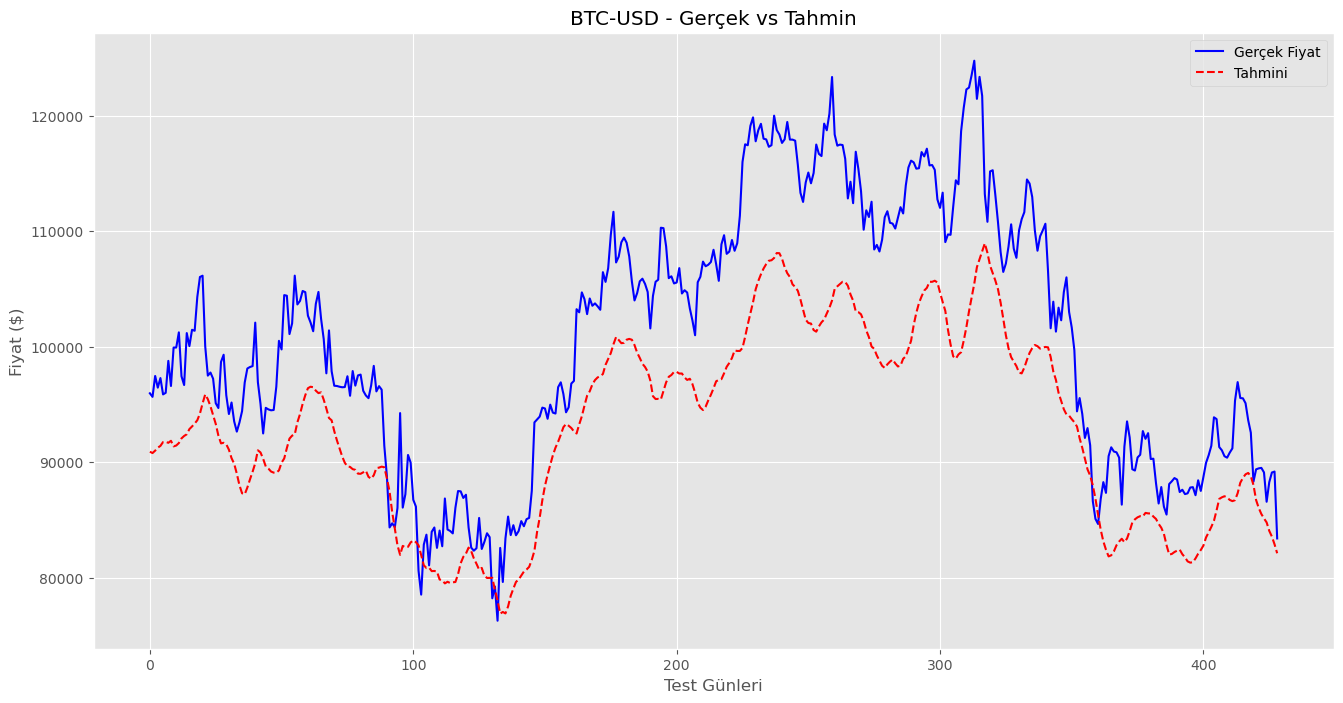

In [32]:
# Test verisiyle tahmin yap
preds_scaled = model.predict(x_test)

# Tahminleri gerçek Dolar değerine geri çevir (Inverse Transform)
preds_real = scaler_y.inverse_transform(preds_scaled)
y_test_real = scaler_y.inverse_transform(y_test)

# Hata Hesaplama
mae = mean_absolute_error(y_test_real, preds_real)
rmse = np.sqrt(mean_squared_error(y_test_real, preds_real))
r2 = r2_score(y_test_real, preds_real)

print(f"\n--- SONUÇLAR ---")
print(f"MAE (Ortalama Hata): {mae:.2f} $")
print(f"R2 Skoru (Başarı Oranı): {r2:.4f}")

# Grafik Çiz
plt.figure(figsize=(16, 8))
plt.plot(y_test_real, label='Gerçek Fiyat', color='blue')
plt.plot(preds_real, label='Tahmini', color='red', linestyle='--')
plt.title(f'{SEMBOL} - Gerçek vs Tahmin')
plt.xlabel('Test Günleri')
plt.ylabel('Fiyat ($)')
plt.legend()
plt.show()

In [35]:
# --- HÜCRE 7: YARIN İÇİN TAHMİN (GÜNCELLENDİ) ---

# Son verileri al
last_data = df[feature_cols].tail(SEQ_LEN).values
last_data_scaled = scaler_x.transform(last_data)

# Boyutlandır (1, 60, Features)
X_future = last_data_scaled.reshape(1, SEQ_LEN, last_data_scaled.shape[1])

# Tahmin Et
future_pred_scaled = model.predict(X_future)
future_pred_real = scaler_y.inverse_transform(future_pred_scaled)[0][0]

# --- DÜZELTME: Sütun adı 'BTC_Close' oldu ---
try:
    last_close = df['BTC_Close'].iloc[-1].item()
except:
    last_close = float(df['BTC_Close'].iloc[-1])

degisim = ((future_pred_real - last_close) / last_close) * 100

print("\n" + "="*40)
print(f"Bugünkü BTC Fiyatı: {last_close:.2f} $")
print(f"MODELİN YARIN TAHMİNİ: {future_pred_real:.2f} $")
print(f"Beklenen Değişim: %{degisim:.2f}")
print("="*40)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

Bugünkü BTC Fiyatı: 83395.79 $
MODELİN YARIN TAHMİNİ: 80891.40 $
Beklenen Değişim: %-3.00


Simülasyon başlatılıyor...
Hesaplanan Piyasa Oynaklığı (Risk): %2.03


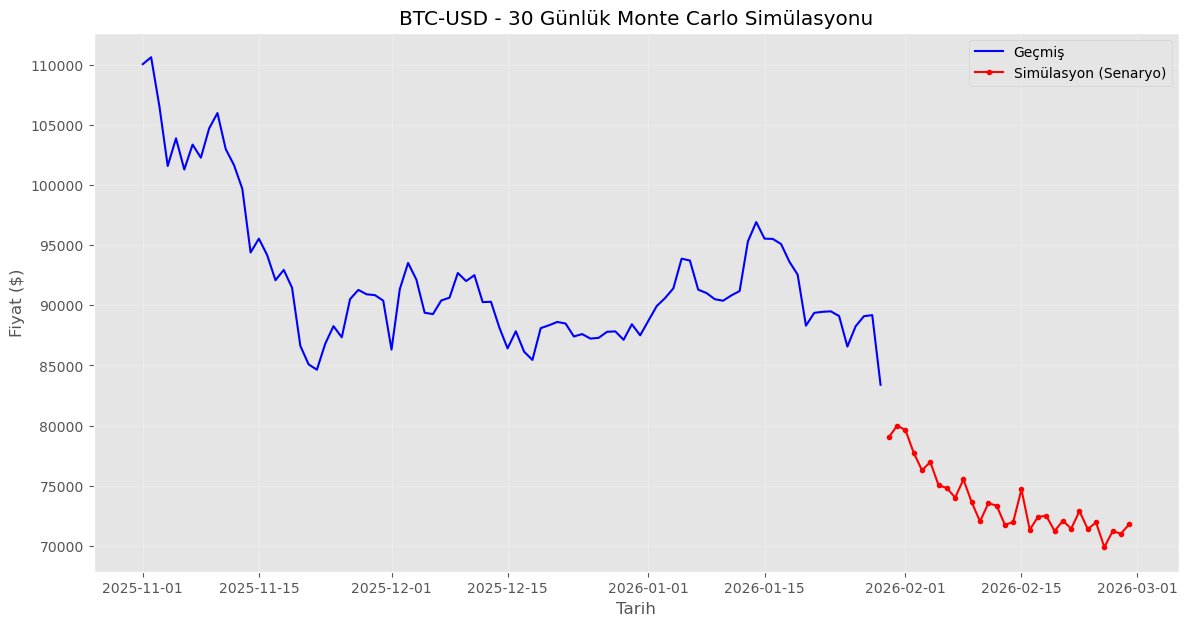

Gelecek 5 Günlük Senaryo:
2026-01-30: 79026.63 $
2026-01-31: 80000.22 $
2026-02-01: 79632.64 $
2026-02-02: 77742.54 $
2026-02-03: 76287.82 $


In [37]:
from datetime import timedelta
import random

def gelecek_30_gun_simulasyon(model, scaler_x, scaler_y, df, seq_len, feature_cols):
    # 1. Volatiliteyi (Oynaklığı) Hesapla
    # Son 60 gündeki günlük değişimlerin standart sapması bize risk oranını verir
    son_donem_degisim = df['BTC_Close'].pct_change().tail(60)
    volatilite = son_donem_degisim.std()
    
    # 2. Son veriyi al ve ölçekle
    last_data = df[feature_cols].tail(seq_len).values
    current_seq = scaler_x.transform(last_data)
    
    gelecek_tahminler = []
    
    print(f"Hesaplanan Piyasa Oynaklığı (Risk): %{volatilite*100:.2f}")
    
    # 3. 30 Günlük Döngü
    for i in range(30):
        # Tahmin yap
        input_seq = current_seq.reshape(1, seq_len, current_seq.shape[1])
        pred_scaled = model.predict(input_seq, verbose=0)
        
        # --- SİHİRLİ DOKUNUŞ: GÜRÜLTÜ EKLEME ---
        # Modelin "düz çizgi" tahminine rastgelelik ekliyoruz.
        # np.random.normal(0, volatilite) -> Sıfır merkezli, volatilite kadar sapabilen sayı üretir.
        
        # Ölçekli dünyada olduğumuz için gürültüyü biraz küçültüyoruz (scaling factor)
        noise = np.random.normal(0, volatilite * 0.5) 
        
        # Tahmine gürültüyü ekle
        simulated_pred = pred_scaled[0][0] + noise
        
        # Tahmini listeye ekle
        gelecek_tahminler.append(simulated_pred)
        
        # 4. Yeni veriyi diziye ekle
        new_row = current_seq[-1].copy()
        new_row[0] = simulated_pred # Yeni (gürültülü) fiyatı ekle
        
        # Diğer indikatörlere (Altın, RSI) de çok ufak rastgelelik verelim ki donuk kalmasın
        for col_idx in range(1, len(new_row)):
            random_wobble = np.random.normal(0, 0.01) # %1'lik ufak oynamalar
            new_row[col_idx] += random_wobble

        # Veri setini kaydır
        current_seq = np.append(current_seq[1:], [new_row], axis=0)

    # 5. Gerçek fiyata dönüştür
    gelecek_tahminler = np.array(gelecek_tahminler).reshape(-1, 1)
    gelecek_tahminler_real = scaler_y.inverse_transform(gelecek_tahminler)
    
    return gelecek_tahminler_real

# --- ÇALIŞTIRMA ---
print("Simülasyon başlatılıyor...")
# Her çalıştırdığında farklı bir yol çizecektir (Olasılıksal Tahmin)
tahminler_30_gun = gelecek_30_gun_simulasyon(model, scaler_x, scaler_y, df, SEQ_LEN, feature_cols)

# --- TARİHLER ---
son_tarih = df.index[-1]
tarih_listesi = [son_tarih + timedelta(days=x+1) for x in range(30)]

# --- GRAFİK ---
plt.figure(figsize=(14, 7))

# Geçmiş
plt.plot(df.index[-90:], df['BTC_Close'].tail(90), label='Geçmiş', color='blue')

# Gelecek (Zikzaklı)
plt.plot(tarih_listesi, tahminler_30_gun, label='Simülasyon (Senaryo)', color='red', linestyle='-', marker='o', markersize=3)

plt.title(f'{SEMBOL} - 30 Günlük Monte Carlo Simülasyonu')
plt.xlabel('Tarih')
plt.ylabel('Fiyat ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Rakamlar
print(f"Gelecek 5 Günlük Senaryo:")
for i in range(5):
    print(f"{tarih_listesi[i].date()}: {tahminler_30_gun[i][0]:.2f} $")


Simülasyon Başlatılıyor...
--- PİYASA RİSK ANALİZİ YAPILIYOR ---
BTC Oynaklığı  : %2.03
Altın Oynaklığı: %1.24
Gümüş Oynaklığı: %4.29


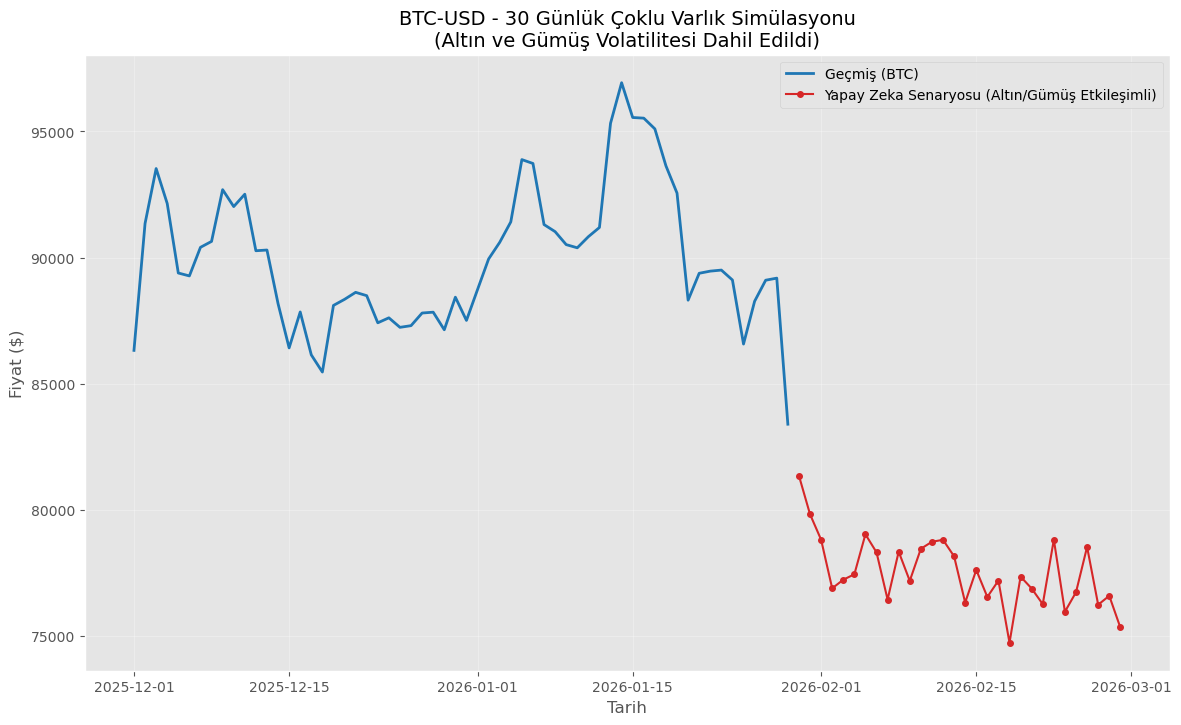


Modelin Ürettiği Senaryodan İlk 5 Gün:
2026-01-30: 81354.19 $
2026-01-31: 79827.66 $
2026-02-01: 78819.04 $
2026-02-02: 76891.83 $
2026-02-03: 77232.61 $


In [39]:
from datetime import timedelta
import random

def gelismis_piyasa_simulasyonu(model, scaler_x, scaler_y, df, seq_len, feature_cols):
    print("--- PİYASA RİSK ANALİZİ YAPILIYOR ---")
    
    # 1. Her Varlığın Kendi Volatilitesini (Oynaklığını) Hesapla
    # Bitcoin çok oynaktır, Altın daha sakindir. Bunu koda öğretiyoruz.
    vol_btc = df['BTC_Close'].pct_change().tail(60).std()
    vol_gold = df['Gold_Close'].pct_change().tail(60).std()
    vol_silver = df['Silver_Close'].pct_change().tail(60).std()
    
    print(f"BTC Oynaklığı  : %{vol_btc*100:.2f}")
    print(f"Altın Oynaklığı: %{vol_gold*100:.2f}")
    print(f"Gümüş Oynaklığı: %{vol_silver*100:.2f}")
    
    # Son verileri al
    last_data = df[feature_cols].tail(seq_len).values
    current_seq = scaler_x.transform(last_data)
    
    gelecek_tahminler = []
    
    # 2. 30 Günlük Döngü
    for i in range(30):
        # A) Model Tahmin Yapar (Mevcut Altın/Gümüş fiyatına bakarak)
        input_seq = current_seq.reshape(1, seq_len, current_seq.shape[1])
        pred_scaled = model.predict(input_seq, verbose=0)
        
        # B) Bitcoin için Gürültü Ekle
        noise_btc = np.random.normal(0, vol_btc * 0.5) 
        btc_simulated = pred_scaled[0][0] + noise_btc
        
        gelecek_tahminler.append(btc_simulated)
        
        # C) Yeni Satır Oluştur ve Metalleri de Simüle Et
        new_row = current_seq[-1].copy()
        
        # Sütun sırasını biliyoruz: 0=BTC, 1=Gold, 2=Silver ...
        # BTC'yi güncelle
        new_row[0] = btc_simulated
        
        # Altın'ı güncelle (Kendi oynaklığına göre rastgele yürüyüş)
        # Mevcut Altın fiyatına %vol_gold kadar değişim ekle
        noise_gold = np.random.normal(0, vol_gold)
        new_row[1] = new_row[1] + noise_gold
        
        # Gümüş'ü güncelle
        noise_silver = np.random.normal(0, vol_silver)
        new_row[2] = new_row[2] + noise_silver
        
        # Diğer teknik indikatörler (RSI vb.) için ufak sabit oynamalar
        for idx in range(3, len(new_row)):
             new_row[idx] += np.random.normal(0, 0.01)

        # D) Veri Setini Kaydır (Eski gün gitti, yeni simüle edilmiş gün geldi)
        current_seq = np.append(current_seq[1:], [new_row], axis=0)

    # Sonuçları Çevir
    gelecek_tahminler = np.array(gelecek_tahminler).reshape(-1, 1)
    gelecek_tahminler_real = scaler_y.inverse_transform(gelecek_tahminler)
    
    return gelecek_tahminler_real

# --- ÇALIŞTIRMA ---
print("\nSimülasyon Başlatılıyor...")
tahminler_senaryo = gelismis_piyasa_simulasyonu(model, scaler_x, scaler_y, df, SEQ_LEN, feature_cols)

# --- GRAFİK ---
plt.figure(figsize=(14, 8))

# Tarihleri ayarla
son_tarih = df.index[-1]
tarih_listesi = [son_tarih + timedelta(days=x+1) for x in range(30)]

# Geçmiş Veri
plt.plot(df.index[-60:], df['BTC_Close'].tail(60), label='Geçmiş (BTC)', color='#1f77b4', linewidth=2)

# Gelecek Tahmini
plt.plot(tarih_listesi, tahminler_senaryo, label='Yapay Zeka Senaryosu (Altın/Gümüş Etkileşimli)', color='#d62728', linestyle='-', marker='o', markersize=4)

plt.title(f'{SEMBOL} - 30 Günlük Çoklu Varlık Simülasyonu\n(Altın ve Gümüş Volatilitesi Dahil Edildi)', fontsize=14)
plt.xlabel('Tarih')
plt.ylabel('Fiyat ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Fiyatları Yazdır
print(f"\nModelin Ürettiği Senaryodan İlk 5 Gün:")
for i in range(5):
    print(f"{tarih_listesi[i].date()}: {tahminler_senaryo[i][0]:.2f} $")